In [1]:
import keras, os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.utils.generic_utils import CustomObjectScope
from keras.utils import to_categorical
from keras.models import Model, load_model
from keras.applications.resnet50 import preprocess_input
from collections import defaultdict
from sklearn.metrics import confusion_matrix

%matplotlib inline

c:\users\zaid\anaconda2\envs\tensorflow3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Helper functions
def show_img(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img, interpolation='nearest')
    plt.show()
    
def test_batch_generator(df, batch_size, img_path, num_classes, \
                    horizontal_flip = True, vertical_flip = True):
    """This generator use a pandas DataFrame to read images from disk.
    """
    N = df.shape[0]
    while True:
        for start in range(0, N, batch_size):
            x_batch = []
            y_batch = []
            if start + batch_size > N: break
            for ind in range(start, start + batch_size):
                name = df.loc[ind, 'file_name']
                img = image.load_img(img_path+'/' + str(name) + '.jpg', target_size=(224, 224))
                img = image.img_to_array(img)
                labelname=df.loc[ind, 'label'] 
                x = preprocess_input(img) # Using tf
                if horizontal_flip:
                    x = flip_axis(x, img_col_axis)
                if vertical_flip:
                    x = flip_axis(x, img_row_axis)
                x_batch.append(x)
                y_batch.append(labelname) 
            x_batch = np.array(x_batch, dtype = np.float32)
            y_batch = to_categorical(y_batch, num_classes = num_classes)
            yield (x_batch, y_batch)
    
def flip_axis(x, axis):
    x = np.asarray(x).swapaxes(axis, 0)
    x = x[::-1, ...]
    x = x.swapaxes(0, axis)
    return x

# Get per class acc and mse
def per_class_scores(conf_mat, label_test):
    res = defaultdict(list)
    Ns = []
    for i in range(conf_mat.shape[0]):
        n = np.sum(conf_mat[i, :])
        acc = conf_mat[i,i] / n
        mse = np.sum([conf_mat[i,j] * ((j-i) ** 2) for j in range(conf_mat.shape[1])]) / n
        Ns.append(n)
        res['MSEs'].append(mse)
        res['Accs'].append(acc)
        print("Label", i, "acc:", acc, " mse:", mse)
    overall_acc = np.sum([conf_mat[i,i] for i in range(conf_mat.shape[0])]) / len(label_test)
    overall_mse = np.dot(res['MSEs'], Ns) / np.sum(Ns)
    print("Overall acc. is", overall_acc)
    print("Overall MSE is", overall_mse)
    res['MSEs'].append(overall_mse)
    res['Accs'].append(overall_acc)
    res['label'] = ['label_' + str(i) for i in range(6)] + ['overall']
    return pd.DataFrame(res)

def test_time_augmentation(model, mode):
    ''' mode = 1: majority vote after argmax,
        mode = 2: sum up all the probabilitys and then argmax '''
    assert(mode == 1 or mode == 2)
    label_test_prob_o = label_test_prob
    label_test_prob_h = model.predict_generator(test_batch_generator(df_test, 
                                                  batch_size=BATCH_SIZE,
                                                  img_path=img_path,
                                                  num_classes=NUM_CLASSES,
                                                  horizontal_flip = True,
                                                  vertical_flip = False),
                                              steps = len(df_test) // BATCH_SIZE,
                                              verbose = 1)
    label_test_prob_v = model.predict_generator(test_batch_generator(df_test, 
                                                  batch_size=BATCH_SIZE,
                                                  img_path=img_path,
                                                  num_classes=NUM_CLASSES,
                                                  horizontal_flip = False,
                                                  vertical_flip = True),
                                              steps = len(df_test) // BATCH_SIZE,
                                              verbose = 1)
    if mode == 1:
        label_test_pred_o = np.argmax(label_test_prob_o, axis=1)
        label_test_pred_h = np.argmax(label_test_prob_h, axis=1)
        label_test_pred_v = np.argmax(label_test_prob_v, axis=1)
        final = []
        for i in range(label_test_pred_o.shape[0]):
            final.append(np.argmax(np.bincount([label_test_pred_o[i],label_test_pred_h[i],label_test_pred_v[i]])))
    else:
        label_test_pred_final = np.sum([label_test_prob_o, label_test_prob_h, label_test_prob_v], axis = 0)
        final = np.argmax(label_test_pred_final, axis=1)
    return final

def model_eval(model_name, pred_values, test_time_augment = False):
    if test_time_augment:
        new_name = model_name + '_test_aug'
    # plot conf_matrix
    new_name = model_name
    conf_mat = confusion_matrix(label_test, pred_values)
    sns.heatmap(conf_mat, annot = True, cmap = 'Blues')
    plt.xlabel('Predicted Value')
    plt.ylabel('True Value')
    plt.savefig(plot_output_path + new_name + '_confmat', fmt = 'png', dpi = 300)
    
    # Save model evaluation, per class acc and mse
    res = per_class_scores(conf_mat, label_test)
    res.to_csv(model_eval_path + new_name + '.csv', index = None)
    
def show_wrong_img(num):
    for i in range(num):
        pred_class = np.argmax(label_test_prob[errors[i]])

        print('Original label: {}, Prediction : {}, confidence : {:.3f}'.format(
            label_test[errors[i]],
            pred_class,
            label_test_prob[errors[i]][pred_class]))

        path = img_path + '/' + str(df_test.loc[errors[i], 'file_name']) + '.jpg'
        show_img(path)

In [3]:
# Define file paths
base_path = "..\\..\\..\\train_data"
file_path = os.path.join(base_path,"file_labels")
img_path = os.path.join(base_path,"bin-images")

In [4]:
# Define model name
BATCH_SIZE = 32
NUM_CLASSES = 6
col_axis = 2
row_axis = 1
img_col_axis = col_axis - 1
img_row_axis = row_axis - 1

model_output_path = "..\\saved_models\\"
model_eval_path = "..\\model_evaluation\\"
plot_output_path = "..\\visualization\\conf_mat\\"
model_name = "resnet(caffe)_adam_"+str(BATCH_SIZE) + "_random_augment"
base_filepath = model_output_path + model_name + ".hdf5"
print(base_filepath)

..\saved_models\resnet(caffe)_adam_32_random_augment.hdf5


In [5]:
df_test = pd.read_csv(file_path+'\\moderate_test.csv', dtype = {'file_name':str, 'lable':np.int8}).drop('sharpness', 1)
print(df_test.shape)

(36197, 2)


In [6]:
# Loading the best model
model = load_model(base_filepath)

In [7]:
label_test_prob = model.predict_generator(test_batch_generator(df_test, 
                                              batch_size=BATCH_SIZE,
                                              img_path=img_path,
                                              num_classes=NUM_CLASSES,
                                              horizontal_flip = False, vertical_flip = False),
                                          steps = len(df_test) // BATCH_SIZE,
                                          verbose = 1)
print("label_test_pred.shape:", label_test_prob.shape)
label_test_pred = np.argmax(label_test_prob, axis=1)
label_test = df_test['label'][:len(label_test_pred)]

1131/1131 [==============================] - 145s 128ms/step
label_test_pred.shape: (36192, 6)


In [8]:
result = defaultdict(list)
result['pred'] = label_test_pred
result['actual'] = label_test
result = pd.DataFrame(result)
result = result.melt(value_vars=['pred', 'actual'])
result.head()

,variable,value
0,pred,5
1,pred,5
2,pred,2
3,pred,3
4,pred,2


In [9]:
# show_wrong_img(num = 3)

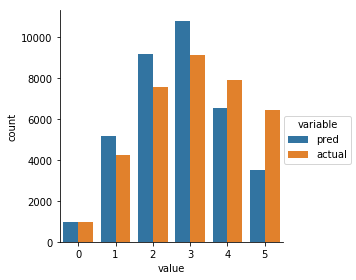

In [10]:
# Plot prediction imbalance
sns.factorplot(x='value', hue='variable', data=result, kind='count')

Label 0 acc: 0.9733879222108496  mse: 0.07062436028659161
Label 1 acc: 0.848527679623086  mse: 0.28645465253239105
Label 2 acc: 0.6552181408301286  mse: 0.47739026654289884
Label 3 acc: 0.531201933640958  mse: 0.6847945506482092
Label 4 acc: 0.36615267947421637  mse: 1.131572295247725
Label 5 acc: 0.32626656274356974  mse: 2.1981293842556506
Overall acc. is 0.5337919982316534
Overall MSE is 0.9441865605658709


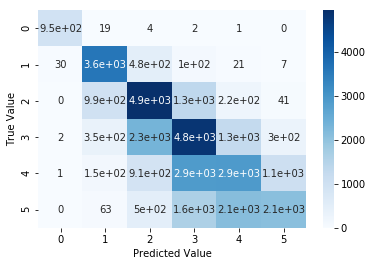

In [11]:
model_eval(model_name, pred_values = label_test_pred)

In [12]:
# final = test_time_augmentation(model, mode = 1)
# model_eval(model_name, pred_values = final, test_time_augment = True)

1131/1131 [==============================] - 147s 130ms/step
Label 0 acc: 0.9754350051177073  mse: 0.07574206755373593
Label 1 acc: 0.8633686690223793  mse: 0.25677267373380447
Label 2 acc: 0.6641029041241214  mse: 0.4552446625116032
Label 3 acc: 0.5557020435069215  mse: 0.6398593715666886
Label 4 acc: 0.3763902932254803  mse: 1.083670374115268
Label 5 acc: 0.32954014029618084  mse: 2.1066250974279033
Overall acc. is 0.5464190981432361
Overall MSE is 0.8982371794871795


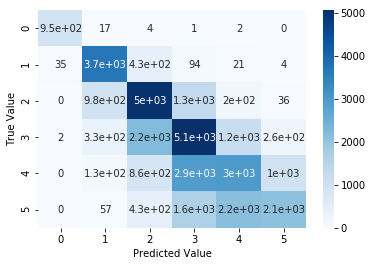

In [13]:
final = test_time_augmentation(model, mode = 2)
model_eval(model_name, pred_values = final, test_time_augment = True)